# NDB1 Analysis

In this notebook we analyse the results from NDB1 experiment (`script_06.py`).

We leverage [set intersection metrics](https://effectivesoftwaredesign.com/2019/02/27/data-science-set-similarity-metrics/).

In [1]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(
    "../data/mlflow_experiment2_runs.tsv", 
    sep='\t',
    dtype={"ag_pos": str, "ag_neg": str}
    )
df["ag_pos"] = df["ag_pos"].replace("5E+094", "5E94")
df["ag_neg"] = df["ag_neg"].replace("5E+094", "5E94")
df = df.loc[df["Name"] == "run_1"]
print(df.shape)
print(df.columns)
df.head(2)

(15, 23)
Index(['Start Time', 'Duration', 'Run ID', 'Name', 'Source Type',
       'Source Name', 'User', 'Status', 'N_closed', 'N_open', 'N_train',
       'ag_neg', 'ag_pos', 'epochs', 'learning_rate', 'closed_f1',
       'closed_precision', 'closed_recall', 'closed_roc_auc', 'open_roc_auc',
       'test_acc', 'test_loss', 'train_loss'],
      dtype='object')


,Start Time,Duration,Run ID,Name,Source Type,Source Name,User,Status,N_closed,N_open,...,epochs,learning_rate,closed_f1,closed_precision,closed_recall,closed_roc_auc,open_roc_auc,test_acc,test_loss,train_loss
0,2022-09-04 11:21:38,1.1h,0bc15534f1504c9083bb891337a89973,run_1,LOCAL,scripts/script_06_SN10_openset_NDB1.py,eugen,FINISHED,9577.0,131283.0,...,50,0.01,0.978363,0.982192,0.974563,0.997441,0.813779,97.681946,0.062607,0.077148
1,2022-09-04 11:21:38,1.0h,619010b228e94338bb3f3c6449e6abc3,run_1,LOCAL,scripts/script_06_SN10_openset_NDB1.py,eugen,FINISHED,9064.0,131283.0,...,50,0.01,0.978897,0.980957,0.976847,0.997930,0.762268,97.892763,0.055780,0.140498


In [3]:
compairr = pd.read_csv("../data/CompAIRR/results/overlaps_d1_output.tsv", sep='\t', index_col=0)
compairr

,1ADQ,1FBI,1H0D,1NSN,1OB1,1WEJ,2YPV,3RAJ,3VRL,5E94,OPENSET
#,,,,,,,,,,,
1ADQ,108197,2763,4036,2521,3100,3112,3872,7331,7957,4899,117186
1FBI,2763,135298,1631,3493,8600,13111,4282,3768,4304,11708,11386
1H0D,4036,1631,165873,3895,378,2512,30477,7965,5906,10339,180466
1NSN,2521,3493,3895,170687,30603,6606,1524,3608,11573,15259,10689
1OB1,3100,8600,378,30603,182923,11764,2045,2209,15462,31647,7400
1WEJ,3112,13111,2512,6606,11764,171387,2388,8193,29120,32231,15077
2YPV,3872,4282,30477,1524,2045,2388,176120,9292,7504,11709,189257
3RAJ,7331,3768,7965,3608,2209,8193,9292,81101,3747,8802,93120
3VRL,7957,4304,5906,11573,15462,29120,7504,3747,212995,24202,23042


In [4]:
def jaccard_index(
    ag1: str, 
    ag2: str, 
    pairwise: pd.DataFrame = compairr
    ) -> float:
    intersection = pairwise.loc[ag1, ag2]
    union = (
        pairwise.loc[ag1, ag1] 
        + pairwise.loc[ag2, ag2] 
        - intersection
    )
    return intersection / union

jaccard_index("1ADQ", "5E94")

0.015961242103274025

In [5]:
df["jaccard_pos_neg"] = df.apply(lambda s: jaccard_index(s["ag_pos"], s["ag_neg"]), axis=1)
df["jaccard_pos_openset"] = df.apply(lambda s: jaccard_index(s["ag_pos"], "OPENSET"), axis=1)
df["jaccard_neg_openset"] = df.apply(lambda s: jaccard_index(s["ag_neg"], "OPENSET"), axis=1)
df["jaccard_closed_openset_sum"] = df["jaccard_pos_openset"] + df["jaccard_neg_openset"]

<AxesSubplot:xlabel='jaccard_pos_neg', ylabel='open_roc_auc'>

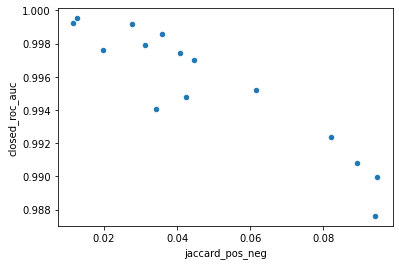

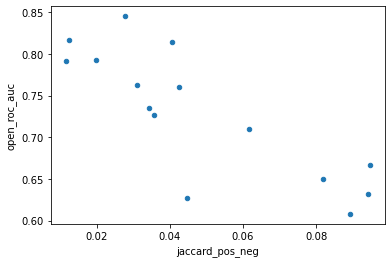

In [6]:
df.plot.scatter(x="jaccard_pos_neg", y="closed_roc_auc")
df.plot.scatter(x="jaccard_pos_neg", y="open_roc_auc")

<AxesSubplot:xlabel='jaccard_pos_openset', ylabel='open_roc_auc'>

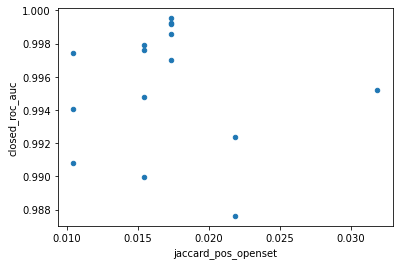

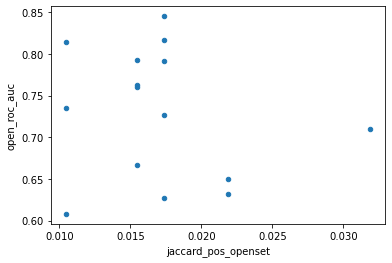

In [7]:
df.plot.scatter(x="jaccard_pos_openset", y="closed_roc_auc")
df.plot.scatter(x="jaccard_pos_openset", y="open_roc_auc")

<AxesSubplot:xlabel='jaccard_neg_openset', ylabel='open_roc_auc'>

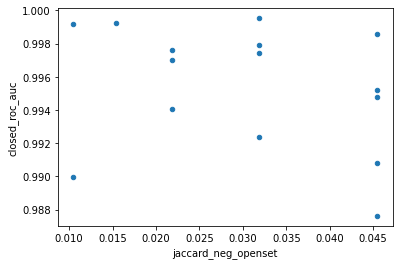

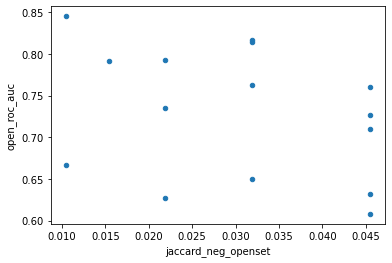

In [8]:
df.plot.scatter(x="jaccard_neg_openset", y="closed_roc_auc")
df.plot.scatter(x="jaccard_neg_openset", y="open_roc_auc")

<AxesSubplot:xlabel='jaccard_closed_openset_sum', ylabel='open_roc_auc'>

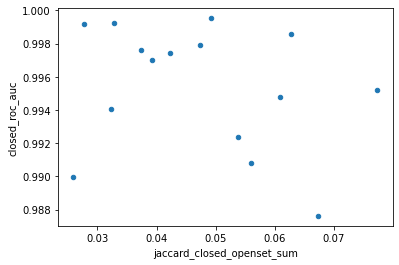

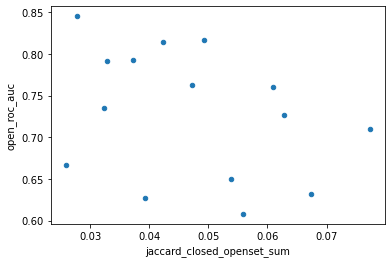

In [9]:
df.plot.scatter(x="jaccard_closed_openset_sum", y="closed_roc_auc")
df.plot.scatter(x="jaccard_closed_openset_sum", y="open_roc_auc")